In [1]:
import random
import pandas as pd
import matplotlib.pyplot as plt
import time
from IPython.display import clear_output
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# SETTING PARAMETERS

cities=20 # number of cities
population_size=100 # size of population
n_best=10 # number of individuals copied from previous population
n_elite=2 # number of individuals saved during roulette selection
n_populations=500 # number of populations/ duration time of the algorithm
win_x=100 # width of the window points are selected from
win_y=100 # height of the window points are selected from
mutation_probability=0.05 # probability of mutating 

In [3]:
# GENERATING POINTS 

def rand_points(num_cities):
    x=[random.randrange(win_x) for _ in range(num_cities)]
    y=[random.randrange(win_y) for _ in range(num_cities)]
    points=pd.DataFrame(data=[x, y]).T
    points.columns=['x','y']
    
    return points


In [4]:
# CALCULATIONG DISTANCES BETWEEN EACH PAIR OF POINTS

def create_dist_frame(points):
    dist=pd.DataFrame()
    for start in points.index:
        d=[0]*len(points.index)
        for dest in points.index: 
            d[dest]=np.sqrt((points['x'][dest]-points['x'][start])**2+(points['y'][dest]-points['y'][start])**2)
        dist[start]=pd.Series(d)
        
    return dist

In [5]:
# CREATING AN INITIAL POPULATION

def initial_population(population_size, points):
    population = pd.DataFrame()
    indexes = list(points.index.values)

    for i in range(population_size):
        p = indexes.copy()
        random.shuffle(p)  
        population[i] = p

    population = population.T
    population.index.name = 'Individual nr'
    
    return population


In [6]:
# EVALUATING A POPULATION

def population_evaluation(population, dist, num_cities):    
    for k in population.index.values:
        len=0
        row=population.iloc[k]
        for i in range(0, num_cities-1):
            len+=dist.loc[row[i],row[i+1]]
        len+=dist.loc[row[0], row[num_cities-1]] # returning to a starting point
        population.loc[k,'sum']=len
        
    return population
        

In [7]:
# RANKING POPULATION BASED ON EVALUATION

def rank(population, population_size):
    distances=population['sum'].sort_values(ascending=True)
    distances = pd.Series(data=range(0, len(distances)), index=distances.index)
    population['rank']=distances
    
    return population


In [8]:
# SELECTION - ROULETTE METHOD

def selection_roulette(population, n_selected, n_elite):
    elites = population.sort_values('sum').iloc[:n_elite] #preserving n_elite best individuals
    rest = population.drop(elites.index)
    vals = 1/rest['sum']
    probabilities = vals/vals.sum()

    #selecting rest of individuals
    selected = np.random.choice(rest.index, size=n_selected-n_elite, replace=False, p=probabilities.values)
    selected = rest.loc[selected]
    combined = pd.concat([elites, selected], ignore_index=True)
    
    return combined.reset_index(drop=True)


In [9]:
# CALCULATING PROBABILITY OF REPRODUCTION

def calc_reproduction_prob(population, curr_size):
    probs=[]
    best_sol=population.iloc[0]['sum']
    for i in range(0, curr_size):
        probs.append(best_sol/population.iloc[i]['sum'])
    probs=probs/sum(probs) #normalizing
    population['reproduction_probability']=probs 
    
    return population


In [10]:
# MUTATION WITH A SET PROBABILITY

def mutate_individual(individual, cities, mutation_probability):
    for i in range(1, cities - 1):
        if np.random.rand() < mutation_probability:  # mutation_ probability condition
            ix1, ix2 = np.random.randint(1, cities-1, 2) 
            individual[ix1], individual[ix2] = individual[ix2], individual[ix1]
            
    return individual

In [11]:
# CROSSOVER

def crossover(parent1, parent2, cities):
    start=np.random.randint(1, cities-2)
    end=np.random.randint(start+1, cities-1)
    child = [None]*cities
    child[start:end] = parent1[start:end]
    i=0
    for gene in parent2:
        if gene not in child:
            while child[i] is not None:
                i+=1
            child[i] = gene
            
    return child

In [12]:
# CREATING CHILDREN WITH CROSSOVER AND MUTATION

def create_children(population, population_size, n_best, cities, mutation_probability):
    population.reset_index(drop=True, inplace=True)
    selected = population.iloc[:n_best].copy()  

    children=[]
    while len(children) < population_size-n_best:
        parents_ix=np.random.choice(population.index, 2, p=population['reproduction_probability'].values)
        parent1=population.iloc[parents_ix[0], :cities].tolist()
        parent2=population.iloc[parents_ix[1], :cities].tolist()

        child=crossover(parent1, parent2, cities)
        child=mutate_individual(child, cities, mutation_probability)
        children.append(child)
    children_df = pd.DataFrame(children, columns=population.columns[:cities])
    new_population = pd.concat([selected, children_df], ignore_index=True)
    
    return new_population


In [13]:
# EXECUTION OF AN ALGORITHM

points=rand_points(cities)
dist=create_dist_frame(points)
population=initial_population(population_size, points)

best_solutions=[]

for i in range(n_populations):
    population = population_evaluation(population, dist, cities)
    population = rank(population, population_size)
    population = selection_roulette(population, n_best, n_elite)
    population = calc_reproduction_prob(population, n_best)
    population = create_children(population, population_size, n_best, cities, mutation_probability)
    best_solution = population.iloc[0] #saving the best solution in each generation for visualisation purpose
    best_solutions.append(best_solution)


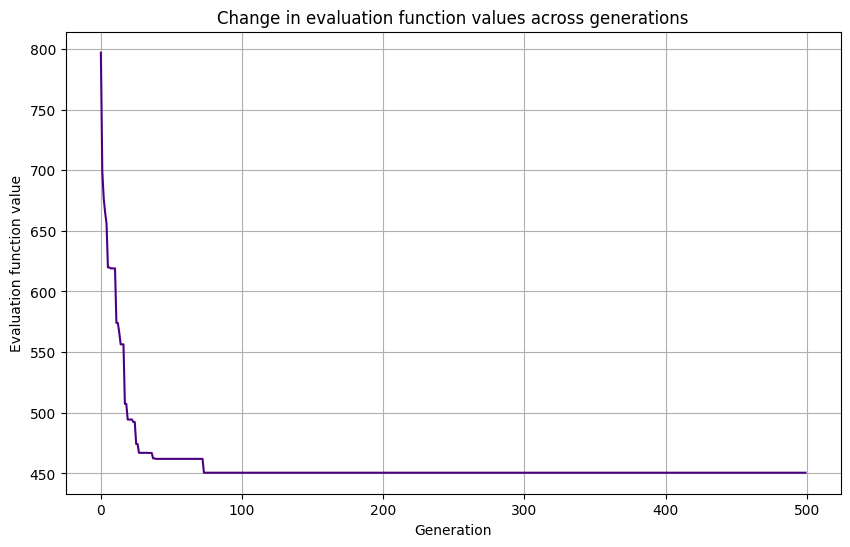

In [14]:
# Change in fitness function values across generations

plt.figure(figsize=(10, 6))
plt.plot(range(n_populations), [solution['sum'] for solution in best_solutions],label="Funkcja przystosowania (najlepsze rozwiązanie)", color='indigo')
plt.xlabel('Generation')
plt.ylabel('Evaluation function value')
plt.title('Change in evaluation function values across generations')
plt.grid(True)
plt.show() 

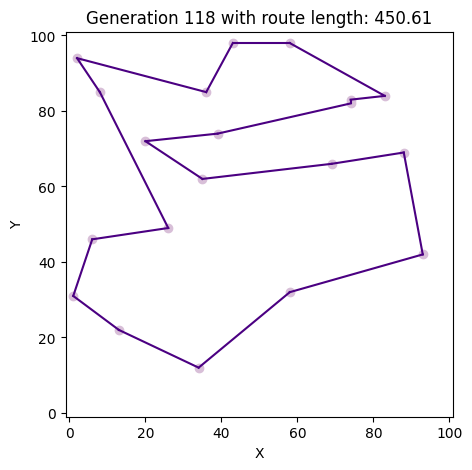

In [ ]:
for i, best in enumerate(best_solutions):
    clear_output(wait=True) 

    route=best[:cities].tolist()+[best[0]]

    x = points.loc[route, 'x'].values
    y = points.loc[route, 'y'].values

    plt.figure(figsize=(5, 5))
    plt.scatter(points['x'], points['y'], color='thistle') 

    for j in range(len(route) - 1):
        plt.plot([x[j], x[j+1]], [y[j], y[j + 1]], color='indigo')
    plt.plot([x[-1], x[0]], [y[-1], y[0]], color='indigo')

    plt.title(f"Generation {i+1} with route length: {best['sum']:.2f}")
    plt.xlim(-1, win_x+1)
    plt.ylim(-1, win_y+1)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

    time.sleep(0.01) # delay between plotting next solution
